In [9]:
import sys
print(sys.version)
print(sys.executable)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
C:\Users\87252\anaconda3\envs\FGSM\python.exe


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets,models


In [11]:
np.random.seed(42)
torch.manual_seed(42)

In [12]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [13]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [14]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [15]:
torch.cuda. is_available()

True

In [16]:
#Defense
# LeNet for NetF


# LeNet for NetF
class NetF(nn.Module):
    def __init__(self):
        super(NetF, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)  # Keeping original LeNet architecture with padding for MNIST
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

# LeNet for NetF1 (a simplified version)
class NetF1(nn.Module):
    def __init__(self):
        super(NetF1, self).__init__()
        # Simplified architecture: fewer filters in convolutional layers and/or fewer neurons in dense layers
        self.conv1 = nn.Conv2d(1, 3, 5, padding=2)  # Reduced number of filters for simplicity
        self.conv2 = nn.Conv2d(3, 8, 5)  # Reduced further
        self.fc1 = nn.Linear(8 * 5 * 5, 60)  # Reduced size
        self.fc2 = nn.Linear(60, 42)  # Reduced size
        self.fc3 = nn.Linear(42, 10)  # Output layer remains the same to match the number of classes

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output


In [17]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [18]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [19]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)

    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1 Loss: 0.5582831383838306 Val_Loss: 0.3350194495746819
Epoch: 2 Loss: 0.20616110366823898 Val_Loss: 0.15110039467430658
Epoch: 3 Loss: 0.1268324386897032 Val_Loss: 0.12324335303611686
Epoch: 4 Loss: 0.09573855411067805 Val_Loss: 0.09485369211441035
Epoch: 5 Loss: 0.07846298359146849 Val_Loss: 0.091314706617845


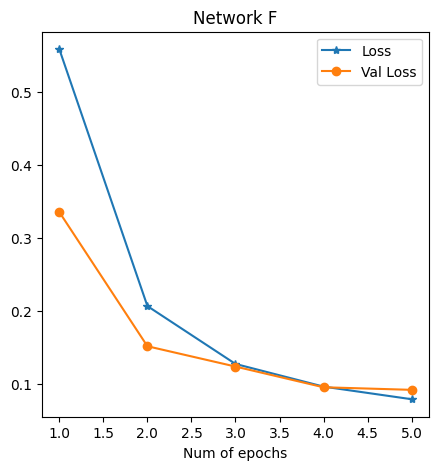

Fitting the model...
Epoch: 1 Loss: 0.7927909290768199 Val_Loss: 0.5047073460269937
Epoch: 2 Loss: 0.36040836024441275 Val_Loss: 0.3007847567505741
Epoch: 3 Loss: 0.24565636608317742 Val_Loss: 0.23270958895677676
Epoch: 4 Loss: 0.18427758615305487 Val_Loss: 0.16922067540521954
Epoch: 5 Loss: 0.14930594363841423 Val_Loss: 0.1492002758696219


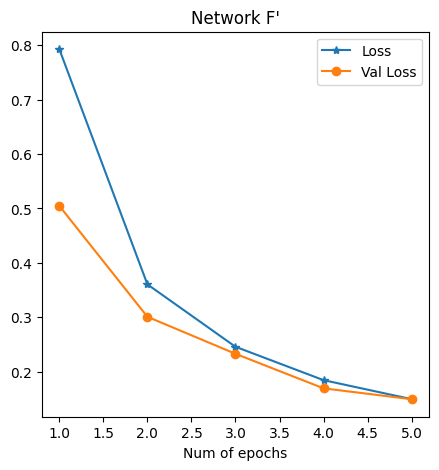

Epsilon: 0	Test Accuracy = 9588 / 10000 = 0.9588
Epsilon: 0.05	Test Accuracy = 9307 / 10000 = 0.9307
Epsilon: 0.1	Test Accuracy = 9304 / 10000 = 0.9304
Epsilon: 0.2	Test Accuracy = 9303 / 10000 = 0.9303
Epsilon: 0.3	Test Accuracy = 9303 / 10000 = 0.9303


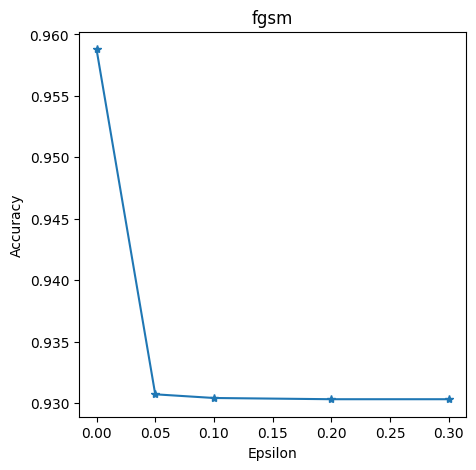

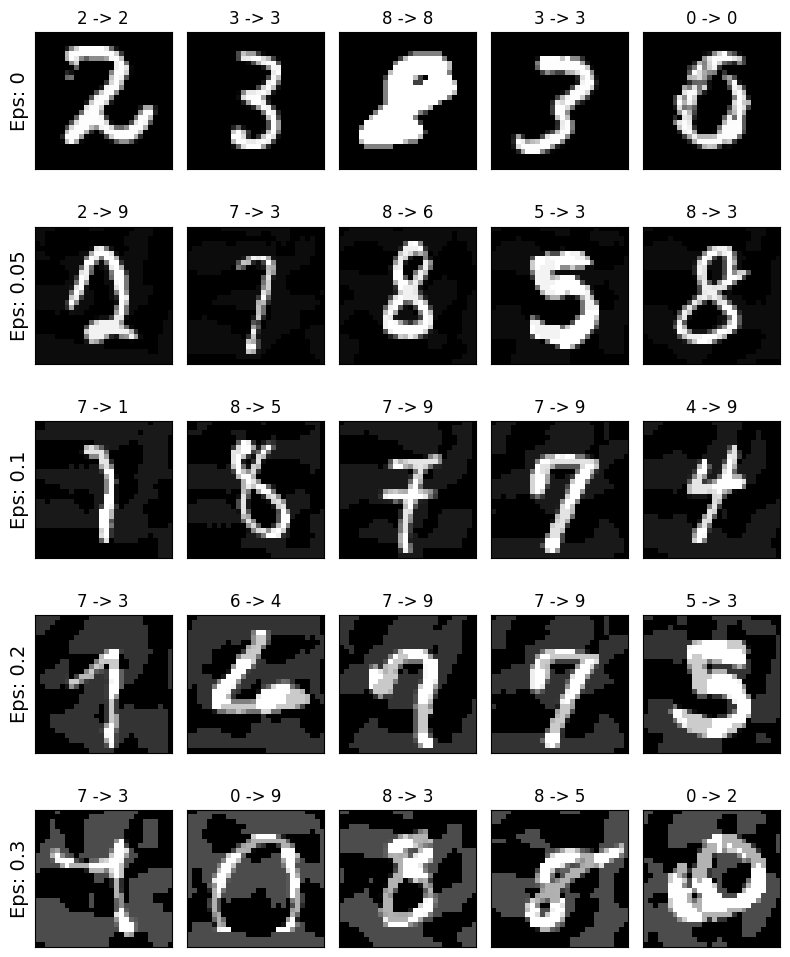

Epsilon: 0	Test Accuracy = 9588 / 10000 = 0.9588
Epsilon: 0.05	Test Accuracy = 9307 / 10000 = 0.9307
Epsilon: 0.1	Test Accuracy = 9304 / 10000 = 0.9304
Epsilon: 0.2	Test Accuracy = 9303 / 10000 = 0.9303
Epsilon: 0.3	Test Accuracy = 9303 / 10000 = 0.9303


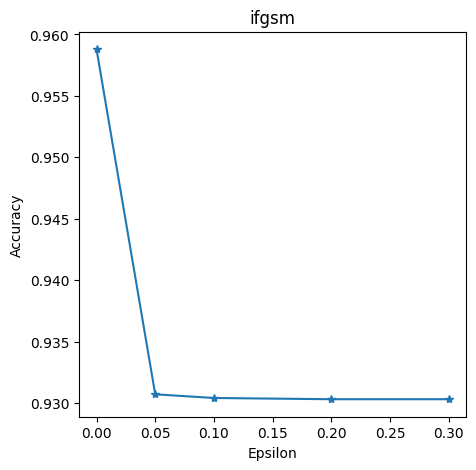

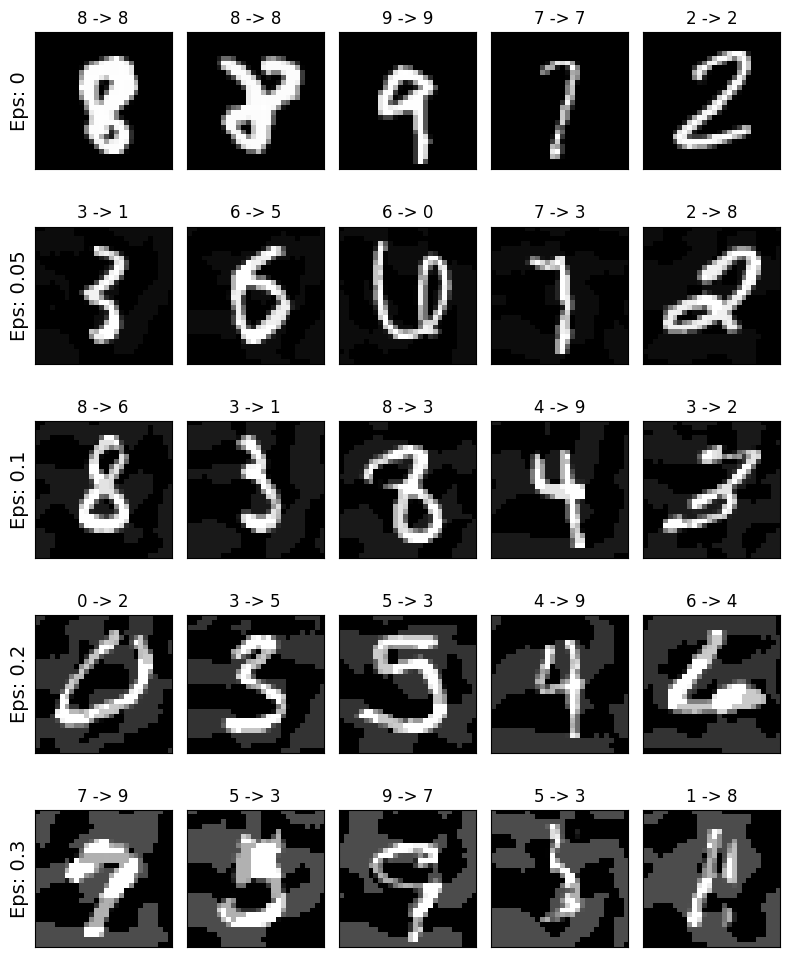

Epsilon: 0	Test Accuracy = 9588 / 10000 = 0.9588
Epsilon: 0.05	Test Accuracy = 9307 / 10000 = 0.9307
Epsilon: 0.1	Test Accuracy = 9304 / 10000 = 0.9304
Epsilon: 0.2	Test Accuracy = 9303 / 10000 = 0.9303
Epsilon: 0.3	Test Accuracy = 9303 / 10000 = 0.9303


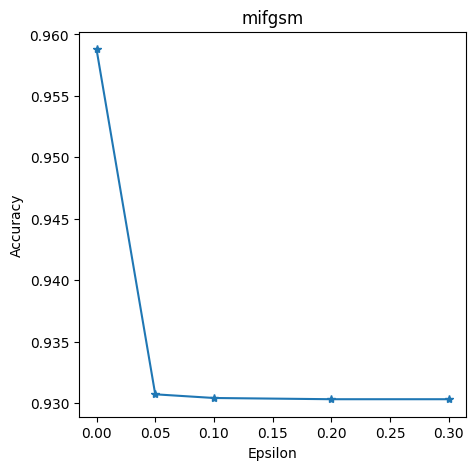

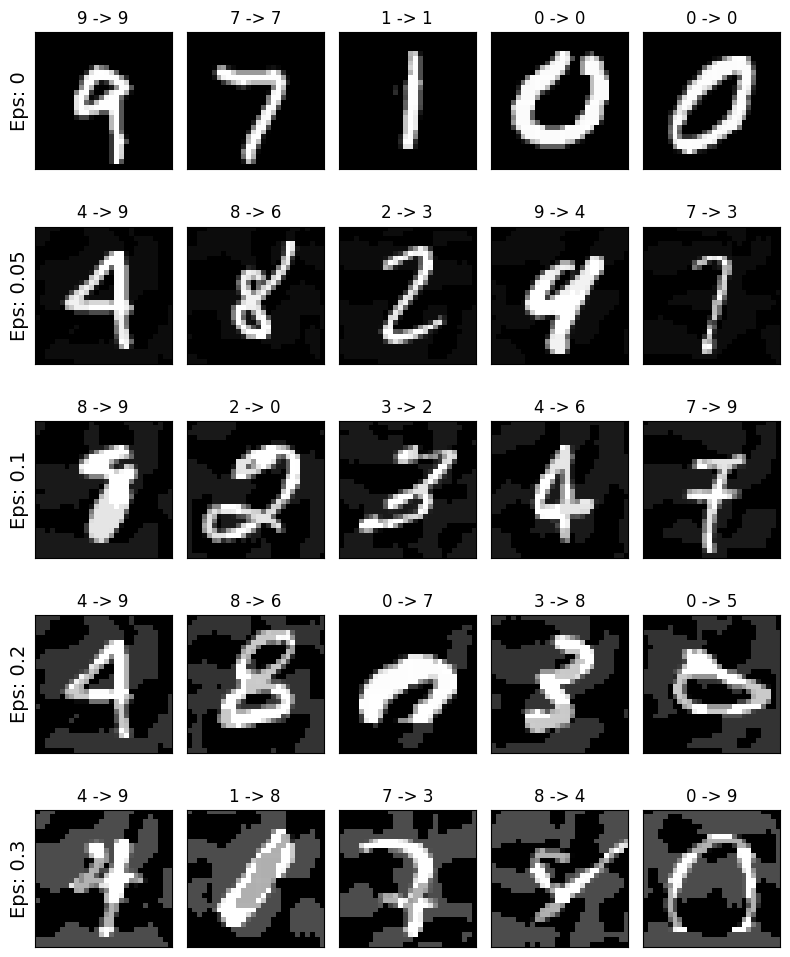

In [20]:
Temp=100
epochs=5
epsilons=[0,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)

In [21]:
# classfication and confusion report

In [22]:
def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  true_labels = []
  pred_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    true_labels.append(target.cpu().numpy())
    pred_labels.append(final_pred.cpu().numpy())
      
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples,true_labels, pred_labels

In [23]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex , true_labels, pred_labels= test(model,device,test_loader,eps,1,"fgsm")
        accuracies.append(acc)
        examples.append(ex)
    true_labels_flat = np.concatenate(true_labels)
    pred_labels_flat = np.concatenate(pred_labels)
    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels_flat, pred_labels_flat)
    print(f"Confusion Matrix for Epsilon={eps}:\n", conf_matrix)

    # Compute classification report
    class_report = classification_report(true_labels_flat, pred_labels_flat, digits=4)
    print(f"Classification Report for Epsilon={eps}:\n", class_report)
    
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

Fitting the model...
Epoch: 1 Loss: 0.5507178085768988 Val_Loss: 0.2951412039976221
Epoch: 2 Loss: 0.2147819245383979 Val_Loss: 0.15636144757495096
Epoch: 3 Loss: 0.13559149828161537 Val_Loss: 0.11368116032057823
Epoch: 4 Loss: 0.10128026782966734 Val_Loss: 0.10674968023778586
Epoch: 5 Loss: 0.08205136867881346 Val_Loss: 0.07865481100730635


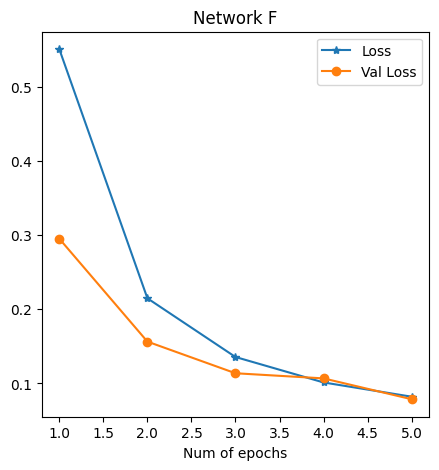

Fitting the model...
Epoch: 1 Loss: 0.7511017434450571 Val_Loss: 0.3995787740287549
Epoch: 2 Loss: 0.31916156312393346 Val_Loss: 0.2617858248132592
Epoch: 3 Loss: 0.22461319220795828 Val_Loss: 0.19084866853832294
Epoch: 4 Loss: 0.17150375347955055 Val_Loss: 0.1690016333894049
Epoch: 5 Loss: 0.1409624952549048 Val_Loss: 0.13765194371721415


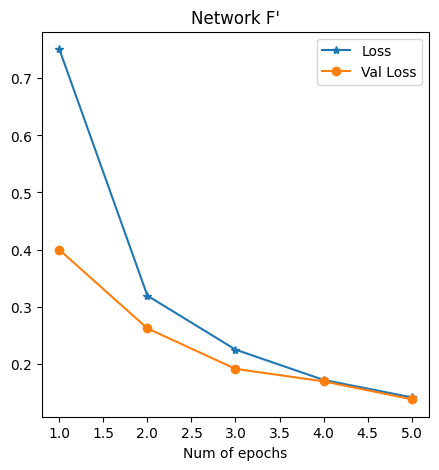

Epsilon: 0.3	Test Accuracy = 9363 / 10000 = 0.9363
Confusion Matrix for Epsilon=0.3:
 [[ 960    0    0    0    1    0    6    0    1    0]
 [   0 1120    0    1    1    0    1    0    3    0]
 [   1    1  972    8    1    0    0    2    4    0]
 [   1    0    5  950    0    7    1    4    3    5]
 [   0    0    1    2  934    0    8    0    1   13]
 [   0    0    0   16    0  831    7    0    3    1]
 [   4    0    2    0    2    2  925    1    1    1]
 [   0    3    1   12    7    1    1  952    1    6]
 [   3    3    6    9    4    3   13    2  863    6]
 [   0    0    2    3   39    4    2    7    4  856]]
Classification Report for Epsilon=0.3:
               precision    recall  f1-score   support

           0     0.9907    0.9917    0.9912       968
           1     0.9938    0.9947    0.9942      1126
           2     0.9828    0.9828    0.9828       989
           3     0.9491    0.9734    0.9611       976
           4     0.9444    0.9739    0.9589       959
           5     0

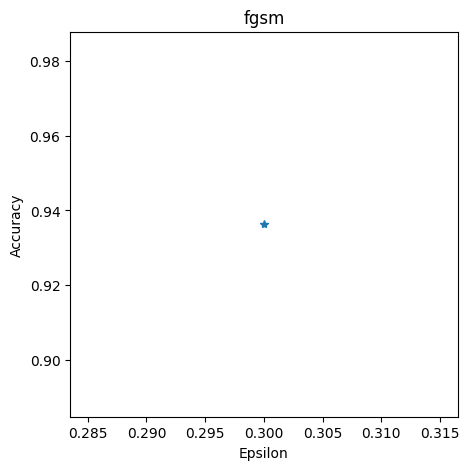

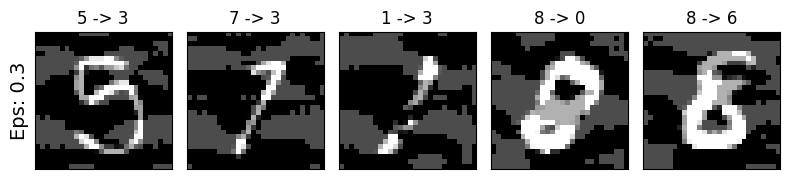

Epsilon: 0.3	Test Accuracy = 9363 / 10000 = 0.9363
Confusion Matrix for Epsilon=0.3:
 [[ 960    0    0    0    1    0    6    0    1    0]
 [   0 1120    0    1    1    0    1    0    3    0]
 [   1    1  972    8    1    0    0    2    4    0]
 [   1    0    5  950    0    7    1    4    3    5]
 [   0    0    1    2  934    0    8    0    1   13]
 [   0    0    0   16    0  831    7    0    3    1]
 [   4    0    2    0    2    2  925    1    1    1]
 [   0    3    1   12    7    1    1  952    1    6]
 [   3    3    6    9    4    3   13    2  863    6]
 [   0    0    2    3   39    4    2    7    4  856]]
Classification Report for Epsilon=0.3:
               precision    recall  f1-score   support

           0     0.9907    0.9917    0.9912       968
           1     0.9938    0.9947    0.9942      1126
           2     0.9828    0.9828    0.9828       989
           3     0.9491    0.9734    0.9611       976
           4     0.9444    0.9739    0.9589       959
           5     0

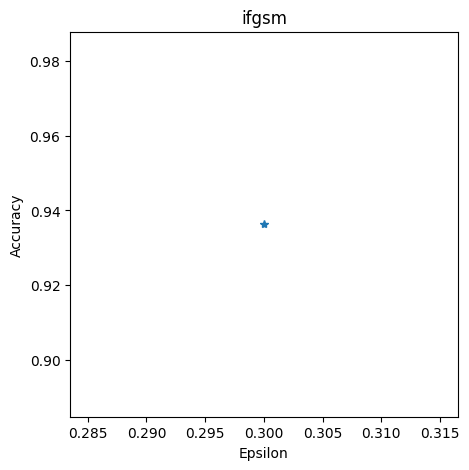

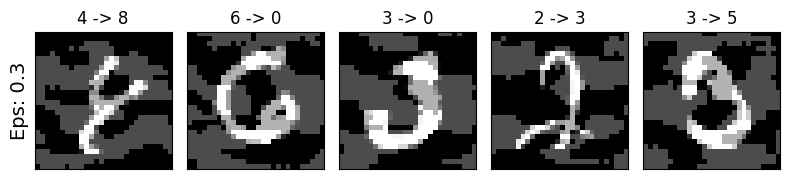

Epsilon: 0.3	Test Accuracy = 9363 / 10000 = 0.9363
Confusion Matrix for Epsilon=0.3:
 [[ 960    0    0    0    1    0    6    0    1    0]
 [   0 1120    0    1    1    0    1    0    3    0]
 [   1    1  972    8    1    0    0    2    4    0]
 [   1    0    5  950    0    7    1    4    3    5]
 [   0    0    1    2  934    0    8    0    1   13]
 [   0    0    0   16    0  831    7    0    3    1]
 [   4    0    2    0    2    2  925    1    1    1]
 [   0    3    1   12    7    1    1  952    1    6]
 [   3    3    6    9    4    3   13    2  863    6]
 [   0    0    2    3   39    4    2    7    4  856]]
Classification Report for Epsilon=0.3:
               precision    recall  f1-score   support

           0     0.9907    0.9917    0.9912       968
           1     0.9938    0.9947    0.9942      1126
           2     0.9828    0.9828    0.9828       989
           3     0.9491    0.9734    0.9611       976
           4     0.9444    0.9739    0.9589       959
           5     0

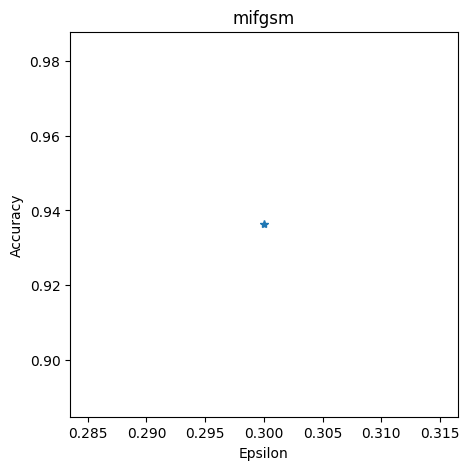

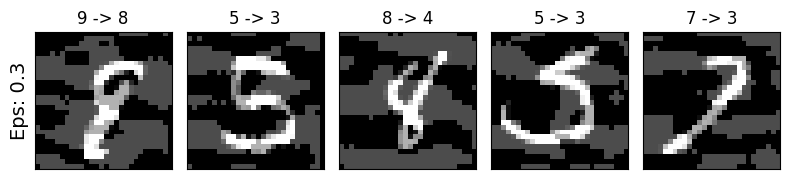

In [29]:
Temp=100
epochs=5
epsilons=[0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)